In [1]:
git_repo = '../../..'

import sys
import os

#sys.path.insert(0, './../../../LinearResponseVariationalBayes.py')
sys.path.insert(0, os.path.join(git_repo, 'BNP_sensitivity/GMM_clustering/'))
#'./../')

# Linear response libraries
import LinearResponseVariationalBayes as vb
import LinearResponseVariationalBayes.SparseObjectives as obj_lib
#import LinearResponseVariationalBayes.ExponentialFamilies as ef

# My libraries
import gmm_clustering_lib as gmm_utils
import modeling_lib 
import functional_sensitivity_lib as fun_sens_lib 
import utils_lib

from scipy import spatial
import scipy.cluster.hierarchy as sch

import matplotlib.pyplot as plt
%matplotlib inline

import time
from tqdm import tqdm

from copy import deepcopy

# Just while you're experimenting
from autograd import numpy as np
from autograd import scipy as sp

# import numpy as np
# import scipy as sp

np.random.seed(453453)

import json 

In [2]:
iris_features, iris_species = utils_lib.load_data()
dim = iris_features.shape[1]

# Get some things that will be useful for plotting.
pca_fit, pc_features, colors1, colors2 = utils_lib.get_plot_data(iris_features)

# Set up the model

In [3]:
prior_params = gmm_utils.get_default_prior_params(dim)
prior_params['alpha'].set(8.0)
prior_params['prior_gamma_df'].set(8)
prior_params['prior_gamma_inv_scale'].set(np.eye(dim) * 0.62)

In [4]:
k_approx = 12
gh_deg = 8
model = gmm_utils.DPGaussianMixture(
    iris_features, k_approx, prior_params, gh_deg, use_logitnormal_sticks=True)

In [5]:
# run k-means init
n_kmeans_init = 50
init_global_free_param = model.cluster_and_set_inits(n_kmeans_init = n_kmeans_init)

In [6]:
t0 = time.time()
best_param, kl_hessian, kl_hessian_corrected, \
init_opt_time, newton_time, x_conv, f_conv, vb_opt = \
model.optimize_full(init_global_free_param,
    init_max_iter=100,
    final_max_iter=500)
t_newton = time.time() - t0

print('Done. ')

BGFS
Iter: 0	 RMSE: 5.4171664084976205	 Objective: 4927.074571257251
Iter: 10	 RMSE: 10.722601299848941	 Objective: 3164.887763988899
Iter: 20	 RMSE: 12.727784407538786	 Objective: 2095.64267039293
Iter: 30	 RMSE: 12.825320826126164	 Objective: 403.25309073085555
Iter: 40	 RMSE: 12.336111507461514	 Objective: -156.2818830513076
Iter: 50	 RMSE: 12.153510031465627	 Objective: -265.9051915783531
Iter: 60	 RMSE: 11.665404774476754	 Objective: -278.95947380457665
Iter: 70	 RMSE: 11.243659114866814	 Objective: -287.3217971112322
Iter: 80	 RMSE: 11.270215074059495	 Objective: -293.1724859597803
Iter: 90	 RMSE: 11.279599774958886	 Objective: -297.93642331028184
Iter: 100	 RMSE: 11.270952653637949	 Objective: -301.5500897148094
         Current function value: -302.542099
         Iterations: 100
         Function evaluations: 110
         Gradient evaluations: 110
Conditioned Newton:
i =  0
Iter: 110	 RMSE: 11.253624423017019	 Objective: -302.5420985282098
Iter: 120	 RMSE: 11.246263059285315	 

In [7]:
best_param = deepcopy(model.global_vb_params.get_free())
prior_free_params = deepcopy(model.prior_params.get_free())
model.set_from_global_free_par(best_param)

moment_model = gmm_utils.InterestingMoments(model)
#linear_sens = gmm_utils.LinearSensitivity(model, moment_model)

In [8]:
kl_hessian = model.objective.fun_free_hessian(best_param)

In [9]:
kl_hessian[1:5, 1:5]

array([[ 7.60384671e+02, -5.25771180e-12, -2.12037829e-16,
        -2.31582102e-12],
       [-5.25771180e-12,  3.39103307e+00,  1.91647366e-03,
         2.60831462e-02],
       [-2.12037829e-16,  1.91647366e-03,  3.63505686e+00,
         1.35393420e-02],
       [-2.31582102e-12,  2.60831462e-02,  1.35393420e-02,
         1.23617881e+00]])

In [19]:
dgdeta = np.zeros(kl_hessian.shape[0])
dgdeta[0] = 1

gh = np.linalg.solve(kl_hessian, g)
print(gh.shape)

(190,)


In [63]:
class VariationalDistributions(object):
    def __init__(self, model, best_param, kl_hessian, dgdeta):
        self.model = model
        self.best_param = best_param
        self.log_q_logit_stick_obj = obj_lib.Objective(
            self.model.global_vb_params, self.get_log_q_logit_stick)
        self.log_q_logit_sticks_obj = obj_lib.Objective(
            self.model.global_vb_params, self.get_log_q_logit_sticks)
        self.set_lr_matrix(kl_hessian, dgdeta)
        
    def set_lr_matrix(self, kl_hessian, dgdeta):
        self.lr_mat = -1 * np.linalg.solve(kl_hessian, dgdeta)
        
    # In the logit_stick space
    def get_log_q_logit_stick(self, logit_v, k):
        mean = self.model.global_vb_params['v_sticks']['mean'].get()[k]
        info = self.model.global_vb_params['v_sticks']['info'].get()[k]
        return -0.5 * (info * (logit_v - mean) ** 2 - np.log(info))

    def get_log_q_logit_sticks(self, logit_v):
        mean = self.model.global_vb_params['v_sticks']['mean'].get()
        info = self.model.global_vb_params['v_sticks']['info'].get()
        return np.sum(-0.5 * (info * (logit_v - mean) ** 2 - np.log(info)))

    def get_log_p0_logit_stick(self, logit_v):
        # See notes -- this is the base prior of stick k in the unconstrained space.
        alpha = self.model.prior_params['alpha'].get()
        return logit_v - (alpha + 1) * np.log1p(np.exp(logit_v))

    def get_single_stick_influence(self, logit_v, k):
        log_q = self.get_log_q_logit_stick(logit_v, k)
        log_p0 = self.get_log_p0_logit_stick(logit_v)
        
        log_q_grad = self.log_q_logit_stick_obj.fun_free_grad(
            self.best_param, logit_v=logit_v, k=k)
        return(self.lr_mat.T @ log_q_grad * np.exp(log_q - log_p0))

    def get_stick_influence(self, logit_v):
        log_q = self.get_log_q_logit_sticks(logit_v)
        log_p0 = self.get_log_p0_logit_stick(logit_v)
        
        log_q_grad = self.log_q_logit_sticks_obj.fun_free_grad(
            self.best_param, logit_v=logit_v)
        return(self.lr_mat.T @ log_q_grad * np.exp(log_q - log_p0))

q_class = VariationalDistributions(model, best_param, kl_hessian, dgdeta)
q_class.model.global_vb_params.set_free(best_param)
print(q_class.get_log_q_logit_stick(0.5, 0))
print(q_class.log_q_logit_stick_obj.fun_free(best_param, logit_v=0.5, k=0))

#print(best_param)
q_class.model.global_vb_params.set_free(best_param)
#print(q_class.log_q_logit_stick_obj.fun_free_grad(best_param, logit_v=0.5, k=0))

print('---------\n')
print(q_class.get_log_q_logit_stick(0.5, 0))
print(q_class.get_log_p0_logit_stick(0.1))

print('\n--------- all:')
# TODO: I don't think this is right.
print(q_class.get_log_q_logit_sticks(0.1))
print(q_class.get_log_p0_logit_stick(0.1))

print('---------\n')
print(q_class.get_single_stick_influence(logit_v=0, k=0))
print(q_class.get_stick_influence(logit_v=0.1))


-11.603569234549244
-11.603569234549244
---------

-11.603569234549244
-6.599569940662139

--------- all:
-85.33033760412582
-6.599569940662139
---------

-1.0197093335387555
-1.713504721278815e-36


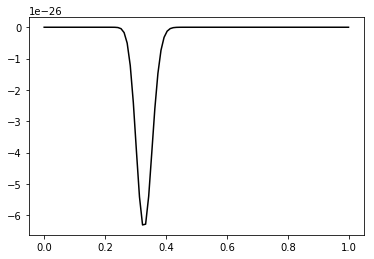

In [59]:
v_grid = np.linspace(1e-3, 1 - 1e-3, num=100)
logit_v_grid = np.log(v_grid / (1 - v_grid))

influence_grid = np.array(
    [ q_class.get_stick_influence(logit_v=logit_v) for
      logit_v in logit_v_grid ])
plt.plot(v_grid, influence_grid, 'k')


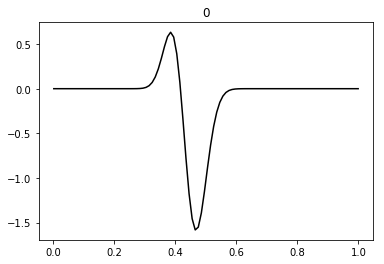

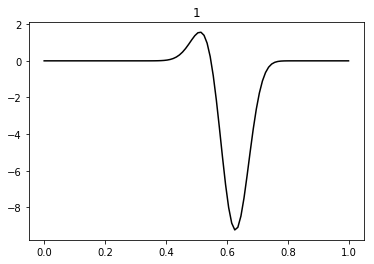

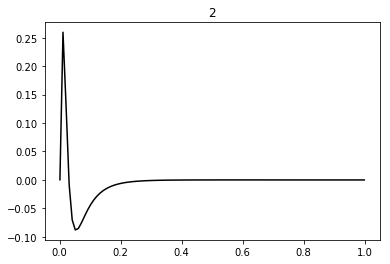

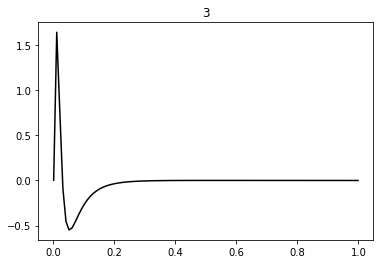

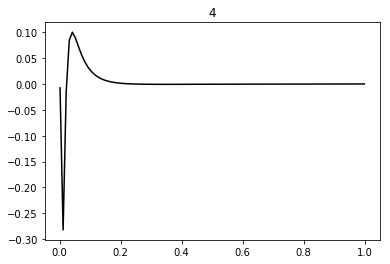

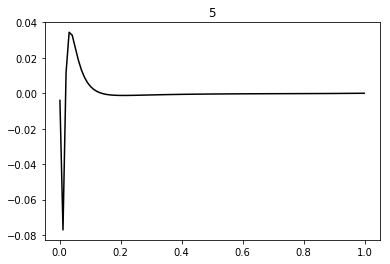

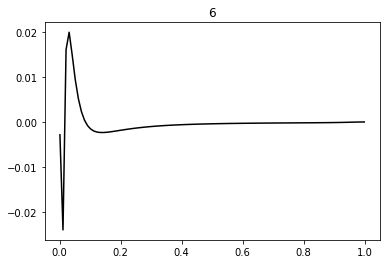

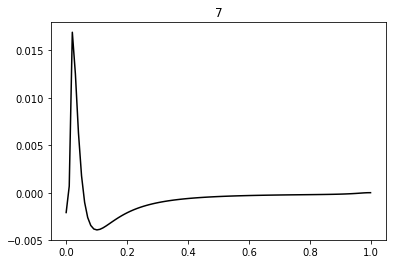

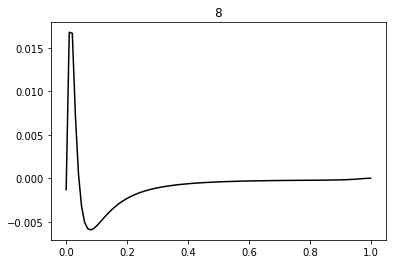

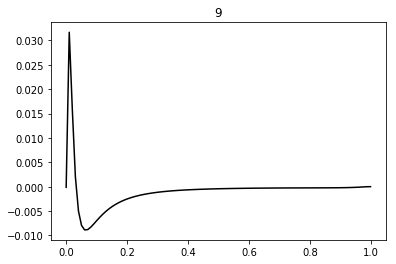

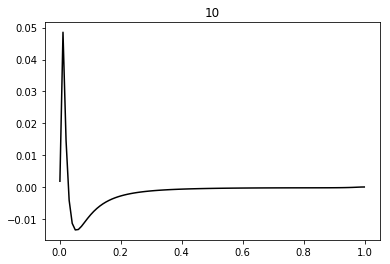

In [55]:
v_grid = np.linspace(1e-3, 1 - 1e-3, num=100)
logit_v_grid = np.log(v_grid / (1 - v_grid))

for k in range(model.k_approx - 1):
    influence_grid = np.array(
        [ q_class.get_single_stick_influence(logit_v=logit_v, k=k) for
          logit_v in logit_v_grid ])
    plt.figure()
    plt.plot(v_grid, influence_grid, 'k')
    plt.title(k)